<a href="https://colab.research.google.com/github/jasinwi22034/SentAlyzer/blob/main/SE_SentimentAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from textblob import TextBlob
from transformers import pipeline
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

file_path = '/content/amazon_product_reviews.csv'
# Function to load and preprocess the data
def preprocess_csv(file_path):
    """
    Loads the CSV file, selects relevant columns, renames them, and removes rows with missing ratings or review texts.

    Args:
        file_path (str): Path to the CSV file.

    Returns:
        pd.DataFrame: Preprocessed dataframe with selected and renamed columns.
    """
    # Load the CSV file
    df = pd.read_csv(file_path)

    # Select and rename the relevant columns
    selected_columns = {
        "id": "review_id",
        "name": "product_name",
        "reviews.text": "review_text",
        "reviews.rating": "rating"
    }

    # Filter and rename columns
    df_filtered = df[list(selected_columns.keys())].rename(columns=selected_columns)

    # Remove rows with missing review_text or rating
    df_filtered = df_filtered.dropna(subset=["review_text", "rating"])

    # Map ratings to sentiments: 1-2 -> negative, 3 -> neutral, 4-5 -> positive
    df_filtered["true_sentiment"] = df_filtered["rating"].apply(lambda x: "negative" if x <= 2 else ("neutral" if x == 3 else "positive"))

    return df_filtered

# Preprocess
preprocessed_df = preprocess_csv(file_path)



In [ ]:
def perform_textblob_sentiment_analysis(df):
    """
    Perform sentiment analysis using TextBlob.

    Args:
        df (pd.DataFrame): Dataframe containing the review texts.

    Returns:
        pd.DataFrame: Dataframe with an additional column for sentiment classification.
    """
    def classify_sentiment(text):
        analysis = TextBlob(text)
        polarity = analysis.sentiment.polarity
        if polarity > 0.1:
            return "positive"
        elif polarity < -0.1:
            return "negative"
        else:
            return "neutral"

    # Apply sentiment classification to the review_text column
    df["textblob_sentiment"] = df["review_text"].apply(classify_sentiment)
    return df

# Perform sentiment analysis
analyzed_df_textblob = perform_textblob_sentiment_analysis(preprocessed_df)

# Display the first few rows with sentiment
print(analyzed_df_textblob.head())

              review_id       product_name  \
0  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
1  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
2  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
3  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
4  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   

                                         review_text  rating true_sentiment  \
0  I initially had trouble deciding between the p...     5.0       positive   
1  Allow me to preface this with a little history...     5.0       positive   
2  I am enjoying it so far. Great for reading. Ha...     4.0       positive   
3  I bought one of the first Paperwhites and have...     5.0       positive   
4  I have to say upfront - I don't like coroporat...     5.0       positive   

  textblob_sentiment  
0           positive  
1           positive  
2           positive  
3           positive  
4           positive  


In [ ]:
from transformers import pipeline

def perform_bert_sentiment_analysis(df):
    """
    Perform sentiment analysis using a BERT-based model from Hugging Face.

    Args:
        df (pd.DataFrame): Dataframe containing the review texts.

    Returns:
        pd.DataFrame: Dataframe with an additional column for sentiment classification.
    """
    # Load the BERT sentiment analysis pipeline
    sentiment_pipeline = pipeline("sentiment-analysis")

    def classify_sentiment(text):
        # Truncate text to 512 tokens if too long
        truncated_text = text[:512] if len(text) > 512 else text
        result = sentiment_pipeline(truncated_text)[0]
        label = result['label']  # Labels are in the format "1 star", "2 stars", etc.
        if label.startswith("1") or label.startswith("2"):
            return "negative"
        elif label.startswith("3"):
            return "neutral"
        else:
            return "positive"


    # Limit the number of rows for testing
    #df_limited = df.head(5)

    # Apply sentiment classification to the review_text column
    df["bert_sentiment"] = df["review_text"].apply(lambda x: classify_sentiment(x) if isinstance(x, str) else "unknown")
    return df

# Perform sentiment analysis with BERT
analyzed_df_bert = perform_bert_sentiment_analysis(preprocessed_df)

# Display the first few rows with sentiment
print(analyzed_df_bert.head())

No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Device set to use cpu


              review_id       product_name  \
0  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
1  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
2  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
3  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
4  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   

                                         review_text  rating true_sentiment  \
0  I initially had trouble deciding between the p...     5.0       positive   
1  Allow me to preface this with a little history...     5.0       positive   
2  I am enjoying it so far. Great for reading. Ha...     4.0       positive   
3  I bought one of the first Paperwhites and have...     5.0       positive   
4  I have to say upfront - I don't like coroporat...     5.0       positive   

  textblob_sentiment bert_sentiment roberta_sentiment  
0           positive       positive          positive  
1           positive       positive          positive  
2           positive       positive          positive  
3           positive    

In [ ]:
def perform_roberta_sentiment_analysis(df):
    """
    Perform sentiment analysis using a RoBERTa-based model from Hugging Face.

    Args:
        df (pd.DataFrame): Dataframe containing the review texts.

    Returns:
        pd.DataFrame: Dataframe with an additional column for sentiment classification.
    """
    # Load the RoBERTa sentiment analysis pipeline
    sentiment_pipeline = pipeline("sentiment-analysis", model="cardiffnlp/twitter-roberta-base-sentiment")

    def classify_sentiment(text):
        # Truncate text to 512 tokens if too long
        truncated_text = text[:512] if len(text) > 512 else text
        result = sentiment_pipeline(truncated_text)[0]
        #print("RoBERTa Sentiment Result:", result)  # Print the result for debugging
        label = result['label']
        if label == "LABEL_0":
            return "negative"
        elif label == "LABEL_1":
            return "neutral"
        elif label == "LABEL_2":
            return "positive"
        else:
            return "unknown"

    # Limit the number of rows for testing
    #df_limited = df.head(5)  # Use only the first 100 rows

    # Apply sentiment classification to the review_text column
    df["roberta_sentiment"] = df["review_text"].apply(lambda x: classify_sentiment(x) if isinstance(x, str) else "unknown")
    return df

# Perform sentiment analysis with RoBERTa
df_roberta = perform_roberta_sentiment_analysis(preprocessed_df)

# Display the first few rows with all sentiment results
print(df_roberta.head(10))

               review_id       product_name  \
0   AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
1   AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
2   AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
3   AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
4   AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
13  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
14  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
15  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
16  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   
17  AVpe7AsMilAPnD_xQ78G  Kindle Paperwhite   

                                          review_text  rating true_sentiment  \
0   I initially had trouble deciding between the p...     5.0       positive   
1   Allow me to preface this with a little history...     5.0       positive   
2   I am enjoying it so far. Great for reading. Ha...     4.0       positive   
3   I bought one of the first Paperwhites and have...     5.0       positive   
4   I have to say upfront - I don't like coroporat...     5.0       positive   
13

TextBlob F1-Score: 0.7591819192851711
BERT F1-Score: 0.7530034418587773
RoBERTa F1-Score: 0.7881694259129909


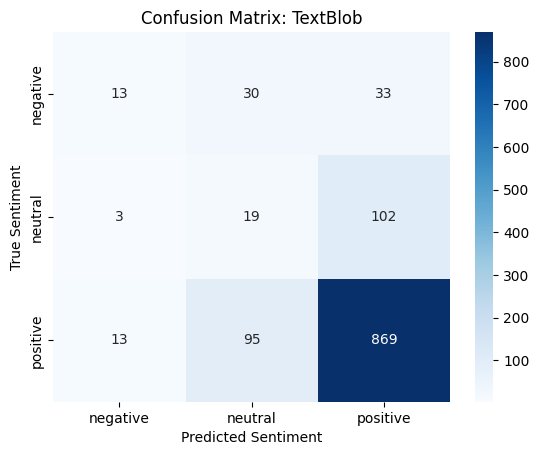

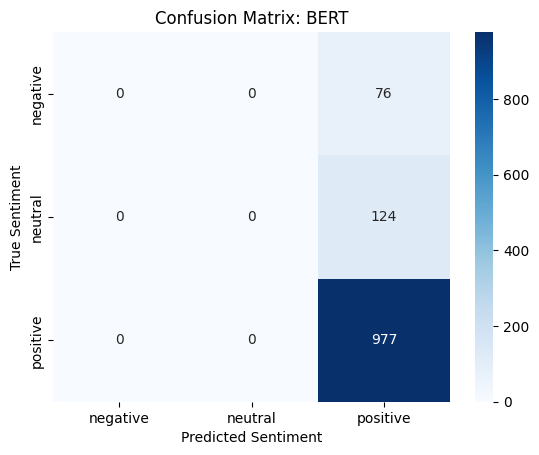

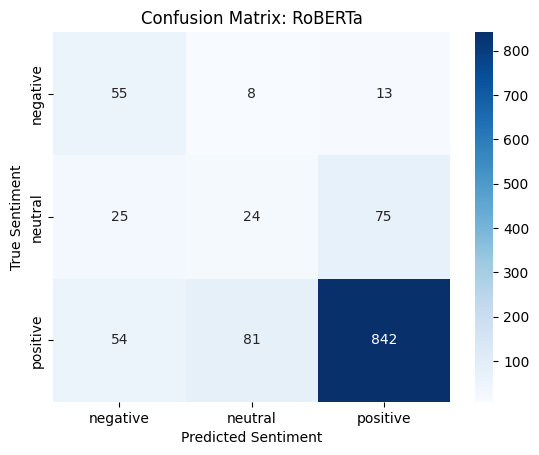

In [ ]:
def plot_confusion_matrix(y_true, y_pred, title):
    """
    Plot a confusion matrix for the given true and predicted labels.

    Args:
        y_true (list): True labels.
        y_pred (list): Predicted labels.
        title (str): Title of the plot.
    """
    cm = confusion_matrix(y_true, y_pred, labels=["negative", "neutral", "positive"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
    plt.title(title)
    plt.xlabel("Predicted Sentiment")
    plt.ylabel("True Sentiment")
    plt.show()

# Calculate F1-scores
true_labels = df_roberta["true_sentiment"]

textblob_f1 = f1_score(true_labels, df_roberta["textblob_sentiment"], average="weighted", labels=["negative", "neutral", "positive"])
bert_f1 = f1_score(true_labels, df_roberta["bert_sentiment"], average="weighted", labels=["negative", "neutral", "positive"])
roberta_f1 = f1_score(true_labels, df_roberta["roberta_sentiment"], average="weighted", labels=["negative", "neutral", "positive"])

# Print F1-scores
print(f"TextBlob F1-Score: {textblob_f1}")
print(f"BERT F1-Score: {bert_f1}")
print(f"RoBERTa F1-Score: {roberta_f1}")

# Plot confusion matrices
plot_confusion_matrix(true_labels, df_roberta["textblob_sentiment"], title="Confusion Matrix: TextBlob")
plot_confusion_matrix(true_labels, df_roberta["bert_sentiment"], title="Confusion Matrix: BERT")
plot_confusion_matrix(true_labels, df_roberta["roberta_sentiment"], title="Confusion Matrix: RoBERTa")
